## Titanic: Machine Learning from Disaster - Predicting Survival Rate of Titanic Passengers
by Mehmet Solmaz <br> March 2020

This is my take on Kaggle Titanic Competition (https://www.kaggle.com/c/titanic/overview). I submitted the outcome of this code and obtained a score of __0.78468__. 

### Methodology
Everything needed to understand the challenge and the data is in this link: https://www.kaggle.com/c/titanic/.<br>
The data is given as Train and Test data. There is useful data that is missing rows. There is some not so useful data that can be discarded. Feature engineering is a must. Here are the main steps I followed:

1. Data wrangling, and understanding data. 
2. Impute missing data and create extra features.
3. Use XGBoost as Binary classifier and mean Cross_Val_Score as metric
4. Bayesion Optimization to optimize hyper-parameters. 

### Results and Evaluation

1. Mean Cross Validation Score of __0.8283__ on training set
2. Test score of __0.7847__ (Slightly overfitted model) 

My first submission had a score of 0.76076 and I was able to improve it by 2% using feature engineering and hyper-parameter optimization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, cross_val_predict, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import timeit
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
# Skopt functions
from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.space import Categorical, Real, Integer
from skopt.utils import use_named_args

In [2]:
# load the training dataset
train_data = pd.read_csv('train.csv',delim_whitespace=None)
train_data.shape

(891, 12)

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
# load the training dataset
test_data = pd.read_csv('test.csv',delim_whitespace=None)
test_data.shape

(418, 11)

In [6]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### First observation about feature data
- Training set has 891, test set has 418 rows.
- Number of features is 11.
- Ticket number and PassengerId are not useful because they are specific to each person and will not give an idea about the survived rate

##### Now lets look at for any missing data

In [7]:
print("# of NaN in every column\n", train_data.isnull().sum(axis = 0))

# of NaN in every column
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [8]:
print("# of NaN in every column\n", test_data.isnull().sum(axis = 0))

# of NaN in every column
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


#### Missing data (Training Set):
- Embarked is only missing 2 data points, we can fill those with Majority Value.
- Cabin is missing majority of data. Either these people don't have a cabin, or this information is not available.
- Age is missing 177 out of 861 data points. We may use an imputer function for Age

#### Missing data (Test Set):
- Fare is missing 1. We can easily fill it with either mean or median value.


### Gameplan for missing values and Feature Engineering
1. Combine train and test data before filling missing values and feature engineering
2. Take care of missing values for column Embarked in train data using Majority Value.
3. Take care of missing Fare value in test data using median Fare.
4. Presume NaN Cabin information means no cabin at all. Categorize passengers into 2, Cabin (1) and NoCabin (0), and replace Cabin column
5. Create new column for family size (SibSp + Parch)
6. Categorize Fare into 5 and create a new column (i.e.FareCat)
7. Use an Imputer Function (Sklearn) to fill NaN for Age column

In [9]:
# Concat train and test data
all_data = pd.concat([train_data,test_data],ignore_index=True)

c:\python3-7\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [10]:
all_data.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1304,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309
1308,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668


In [11]:
#look at missing values again
print("# of NaN in every column\n", all_data.isnull().sum(axis = 0))

# of NaN in every column
 Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64


In [12]:
# Lets start with Embarked
all_data.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [13]:
# fill the NaN with S, since it is the highest used 
all_data['Embarked'] = all_data['Embarked'].fillna('S')

In [14]:
# fill Fare with Median value
all_data['Fare'] = all_data['Fare'].fillna(all_data['Fare'].median())

In [15]:
# Number of unique cabin names
len(all_data.Cabin.value_counts())

186

In [16]:
# Create a new column and label with 0 (has Cabin) and 1 (no Cabin)
all_data['New_Cabin'] = np.where(all_data['Cabin'].isnull(), 0, 1)

In [17]:
# create a new feature column (Size of Family)
all_data['FamSize'] = all_data['SibSp'] + all_data['Parch']

In [18]:
# Categorize Fare data into 5 and create a new feature column
all_data['CatFare']= pd.qcut(all_data['Fare'], q=5, labels=False)

In [19]:
all_data.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,New_Cabin,FamSize,CatFare
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,0,1,0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,1,1,4


In [20]:
all_data.tail(2)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,New_Cabin,FamSize,CatFare
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,0,0,1
1308,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668,0,2,3


In [21]:
print("# of NaN in every column\n", all_data.isnull().sum(axis = 0))

# of NaN in every column
 Age             263
Cabin          1014
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
New_Cabin         0
FamSize           0
CatFare           0
dtype: int64


In [22]:
feature_columns = ['Age','Sex','Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked', 'New_Cabin', 'FamSize', 'CatFare']

In [23]:
X = all_data[feature_columns]

In [24]:
X.count()

Age          1046
Sex          1309
Pclass       1309
SibSp        1309
Parch        1309
Fare         1309
Embarked     1309
New_Cabin    1309
FamSize      1309
CatFare      1309
dtype: int64

In [25]:
X.dtypes

Age          float64
Sex           object
Pclass         int64
SibSp          int64
Parch          int64
Fare         float64
Embarked      object
New_Cabin      int32
FamSize        int64
CatFare        int64
dtype: object

In [26]:
label_encoder = LabelEncoder()
X['Sex'] = label_encoder.fit_transform(X['Sex'])

c:\python3-7\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
label_encoder_Embarked = LabelEncoder()
X['Embarked'] = label_encoder.fit_transform(X['Embarked'])

c:\python3-7\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
X.head()

,Age,Sex,Pclass,SibSp,Parch,Fare,Embarked,New_Cabin,FamSize,CatFare
0,22.0,1,3,1,0,7.2500,2,0,1,0
1,38.0,0,1,1,0,71.2833,0,1,1,4
2,26.0,0,3,0,0,7.9250,2,0,0,1
3,35.0,0,1,1,0,53.1000,2,1,1,4
4,35.0,1,3,0,0,8.0500,2,0,0,1


In [29]:
# Sklearn IterativeImputer for filling NaN Age values
imputer = IterativeImputer(random_state=0)

In [30]:
X_imputed = imputer.fit_transform(X)

In [31]:
X_imputed.shape

(1309, 10)

In [32]:
X = pd.DataFrame(data=X_imputed, index=X.index, columns=X.columns)

In [33]:
print("# of NaN in every column\n", X.isnull().sum(axis = 0))

# of NaN in every column
 Age          0
Sex          0
Pclass       0
SibSp        0
Parch        0
Fare         0
Embarked     0
New_Cabin    0
FamSize      0
CatFare      0
dtype: int64


In [34]:
# After imputing Age, lets round it to nearest integer
X['Age'] = X.Age.round()

In [35]:
X.tail()

,Age,Sex,Pclass,SibSp,Parch,Fare,Embarked,New_Cabin,FamSize,CatFare
1304,27.0,1.0,3.0,0.0,0.0,8.0500,2.0,0.0,0.0,1.0
1305,39.0,0.0,1.0,0.0,0.0,108.9000,0.0,1.0,0.0,4.0
1306,38.0,1.0,3.0,0.0,0.0,7.2500,2.0,0.0,0.0,0.0
1307,27.0,1.0,3.0,0.0,0.0,8.0500,2.0,0.0,0.0,1.0
1308,22.0,1.0,3.0,1.0,1.0,22.3583,0.0,0.0,2.0,3.0


In [36]:
# Now lets split Train and Test data 
X_train = X.iloc[:891,:]
X_test = X.iloc[891:,:]

In [37]:
y_train = train_data['Survived']

In [38]:
X_train.head()

,Age,Sex,Pclass,SibSp,Parch,Fare,Embarked,New_Cabin,FamSize,CatFare
0,22.0,1.0,3.0,1.0,0.0,7.2500,2.0,0.0,1.0,0.0
1,38.0,0.0,1.0,1.0,0.0,71.2833,0.0,1.0,1.0,4.0
2,26.0,0.0,3.0,0.0,0.0,7.9250,2.0,0.0,0.0,1.0
3,35.0,0.0,1.0,1.0,0.0,53.1000,2.0,1.0,1.0,4.0
4,35.0,1.0,3.0,0.0,0.0,8.0500,2.0,0.0,0.0,1.0


In [39]:
X_test.shape

(418, 10)

In [40]:
y_train.shape

(891,)

#### Hyper-parameter optimization using Skopt Library. I am specifically using Bayesian Optimization

In [41]:
space = [
    Real(0.6, 0.7, name="colsample_bylevel"),
    Real(0.6, 0.7, name="colsample_bytree"),
    Real(0.01, 1, name="gamma"),
    Real(0.0001, 1, name="learning_rate"),
    Real(0.1, 10, name="max_delta_step"),
    Integer(6, 15, name="max_depth"),
    Real(10, 500, name="min_child_weight"),
    Integer(10, 100, name="n_estimators"),
    Real(0.1, 100, name="reg_alpha"),
    Real(0.1, 100, name="reg_lambda"),
    Real(0.4, 0.7, name="subsample"),
]

In [42]:
# XGBoost Classifier
model = XGBClassifier(random_state=0)

In [43]:
# pass arguments to model, and use mean cross validation score as metric
@use_named_args(space)
def objective(**params):
    model.set_params(**params)

    return -np.mean(cross_val_score(model, X_train, y_train, cv=5, n_jobs=1))

In [44]:
# optimize, takes less than a minute
starttime = timeit.default_timer()
model_gp = gp_minimize(objective, space, n_calls=50, random_state=0)
print("Hyperparameter Optimization Time is :", timeit.default_timer() - starttime)

Hyperparameter Optimization Time is : 50.85057009999991


In [45]:
"Best score=%.4f" % model_gp.fun

'Best score=-0.8283'

In [48]:
# tuned model parameters
model_gp.x

[0.621387255812436,
 0.7,
 0.01,
 0.7893787820946817,
 7.182235017219347,
 8,
 10.0,
 100,
 3.1704827739161803,
 0.1,
 0.7]

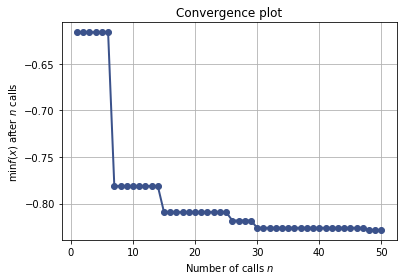

In [49]:
## see how Cross Validation Score evolved during 50 runs
plot_convergence(model_gp)

In [50]:
# set XGBoost parameters
model_hyper_params = ['colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step',
                        'max_depth', 'min_child_weight', 'n_estimators', 'reg_alpha', 'reg_lambda', 'subsample']
params = {model_hyper_params[i]: model_gp.x[i] for i, j in enumerate(model_hyper_params)}
model.set_params(**params)

XGBClassifier(base_score=None, booster=None,
              colsample_bylevel=0.621387255812436, colsample_bynode=None,
              colsample_bytree=0.7, gamma=0.01, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.7893787820946817,
              max_delta_step=7.182235017219347, max_depth=8,
              min_child_weight=10.0, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=0,
              reg_alpha=3.1704827739161803, reg_lambda=0.1,
              scale_pos_weight=None, subsample=0.7, tree_method=None,
              validate_parameters=False, verbosity=None)

In [51]:
# Fit model so that XGBoost Model uses these parameters for test data
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.621387255812436,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.01, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.7893787820946817,
              max_delta_step=7.182235017219347, max_depth=8,
              min_child_weight=10.0, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0,
              reg_alpha=3.1704827739161803, reg_lambda=0.1, scale_pos_weight=1,
              subsample=0.7, tree_method=None, validate_parameters=False,
              verbosity=None)

In [52]:
X_test.head()

,Age,Sex,Pclass,SibSp,Parch,Fare,Embarked,New_Cabin,FamSize,CatFare
891,34.0,1.0,3.0,0.0,0.0,7.8292,1.0,0.0,0.0,0.0
892,47.0,0.0,3.0,1.0,0.0,7.0000,2.0,0.0,1.0,0.0
893,62.0,1.0,2.0,0.0,0.0,9.6875,1.0,0.0,0.0,1.0
894,27.0,1.0,3.0,0.0,0.0,8.6625,2.0,0.0,0.0,1.0
895,22.0,0.0,3.0,1.0,1.0,12.2875,2.0,0.0,2.0,2.0


In [53]:
X_test.shape

(418, 10)

In [54]:
Survived = model.predict(X_test)

In [55]:
Survived

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [56]:
len(Survived)

418

In [58]:
df_out_data = {'PassengerID':test_data['PassengerId'],'Survived':Survived}

In [59]:
df_out = pd.DataFrame(df_out_data)

In [60]:
df_out.head()

,PassengerID,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [61]:
# save as csv file to Kaggle Submission
df_out.to_csv('gender_submission10.csv', index=False)